# Setup the Environment
We are going to use YOLOv5 model for training.
so lets clone and install the YOLO from github repo

In [53]:
# !git clone https://github.com/ultralytics/yolov5
# %cd yolov5
# !pip install -qr requirements.txt

In [54]:
# Import required libraries
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [55]:
input_data = '/home/dung/Desktop/dataset/face-mask-detection'
output_data = 'home/dung/Desktop/face-mask-dection/notebook'

# Read and Handle Annotations
Read the data from .xml files
<br>
Extract filename and dimensions of the bouding boxes
<br>
and import that data into a pandas DataFrame

In [56]:
annotations_path = "/home/dung/Desktop/dataset/face-mask-detection/annotations"
images_path = "/home/dung/Desktop/dataset/face-mask-detection/images"

In [57]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

for anno in glob.glob(annotations_path+"/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [58]:
df=pd.DataFrame(dataset)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax
0,maksssksksss647,mask_weared_incorrect,400,265,21,40,66,87
1,maksssksksss647,without_mask,400,265,82,21,108,43
2,maksssksksss647,with_mask,400,265,134,44,152,67
3,maksssksksss647,with_mask,400,265,150,75,182,109
4,maksssksksss647,with_mask,400,265,62,159,145,240


In [59]:
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

df['class'] = df['name'].map(name_dict)

In [60]:
np.sort(df.name.unique())

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

# Train Test Split
Split the dataset into training testing and validation set
<br>
separate the data in different folder inside the Yolo directory
<br>
and Normalize data

In [61]:
fileNames = [*os.listdir("/home/dung/Desktop/dataset/face-mask-detection/images")]
print('There are {} images in the dataset'.format(len(fileNames)))

There are 853 images in the dataset


In [62]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fileNames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("="*30)
print("Length of Valid =",len(val))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of Valid = 61
Length of test = 25


In [63]:
# create separate train test and validation dir inside yolo/data/
os.chdir('/home/dung/Desktop/face-mask-detection/notebook')
# os.mkdir('./yolov5/data/train')
# os.mkdir('./yolov5/data/val')
# os.mkdir('./yolov5/data/test')
# os.mkdir('./yolov5/data/train/images')
# os.mkdir('./yolov5/data/train/labels')
# os.mkdir('./yolov5/data/test/images')
# os.mkdir('./yolov5/data/test/labels')
# os.mkdir('./yolov5/data/val/images')
# os.mkdir('./yolov5/data/val/labels')

In [64]:
from PIL import Image

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open(input_data + "/images/" + image)
        img1 = img.resize((640, 480))
        _ = img1.save("/home/dung/Desktop/face-mask-detection/notebook/yolov5/data/train/images" + image)

copyImages(train, "train")
copyImages(val, "val")
copyImages(test, "test")

In [65]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss647,mask_weared_incorrect,400,265,21,40,66,87,1
1,maksssksksss647,without_mask,400,265,82,21,108,43,2
2,maksssksksss647,with_mask,400,265,134,44,152,67,0
3,maksssksksss647,with_mask,400,265,150,75,182,109,0
4,maksssksksss647,with_mask,400,265,62,159,145,240,0


In [66]:
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

In [67]:
df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [68]:
df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

In [69]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_height,box_width
0,maksssksksss647,mask_weared_incorrect,400,265,33,72,105,157,1,0.107813,0.238542,0.112500,0.177083
1,maksssksksss647,without_mask,400,265,131,38,172,77,2,0.236719,0.119792,0.064062,0.081250
2,maksssksksss647,with_mask,400,265,214,79,243,121,0,0.357031,0.208333,0.045312,0.087500
3,maksssksksss647,with_mask,400,265,240,135,291,197,0,0.414844,0.345833,0.079687,0.129167
4,maksssksksss647,with_mask,400,265,99,288,232,434,0,0.258594,0.752083,0.207813,0.304167


In [70]:
df = df.astype('string')

In [73]:
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class'] + " "+row["x_center"] + " " + row["y_center"]\
                         + " " + row["box_height"] + " " + row["box_width"])
            
        text = "\n".join(box_list)
        with open("/home/dung/Desktop/face-mask-detection/notebook/yolov5/data/train/labels" + name + ".txt", "w") as file:
            file.write(text)


create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

# Configure the Model

In [74]:
# go to YOLO directory
%cd yolov5

/home/dung/Desktop/face-mask-detection/notebook/yolov5


In [75]:
# to display images
from IPython.display import Image, clear_output
import torch
from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v6.1-105-gd257c75 torch 1.12.0+cu102 CPU


Setup complete ✅ (8 CPUs, 15.4 GB RAM, 47.3/60.3 GB disk)


In [76]:
# configure .yaml file to guide the model for training
yaml_text = """train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml

train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

In [77]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [78]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

In [80]:
# train yolov5s on custom data for 100 epochs
# time its performance
# we are going to using pre-trained weights from yolov5.pt model

start = datetime.now()
!python3 train.py --img 640 --batch 32 --epochs 50 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache
end = datetime.now()

train: weights=yolov5s.pt, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 2576, done.
remote: Counting objects: 100% (716/716), done.
remote: Compressing objects: 100% (5/5), done.
Command 'git fetch && git config --get remote.origin.url' timed out after 5 seconds
YOLOv5 🚀 v6.1-105-gd257c75 torch 1.12.0+cu102 CPU228.00 KiB/s

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8,

In [81]:
print("Runtime =",end-start)

Runtime = 0:00:27.110029


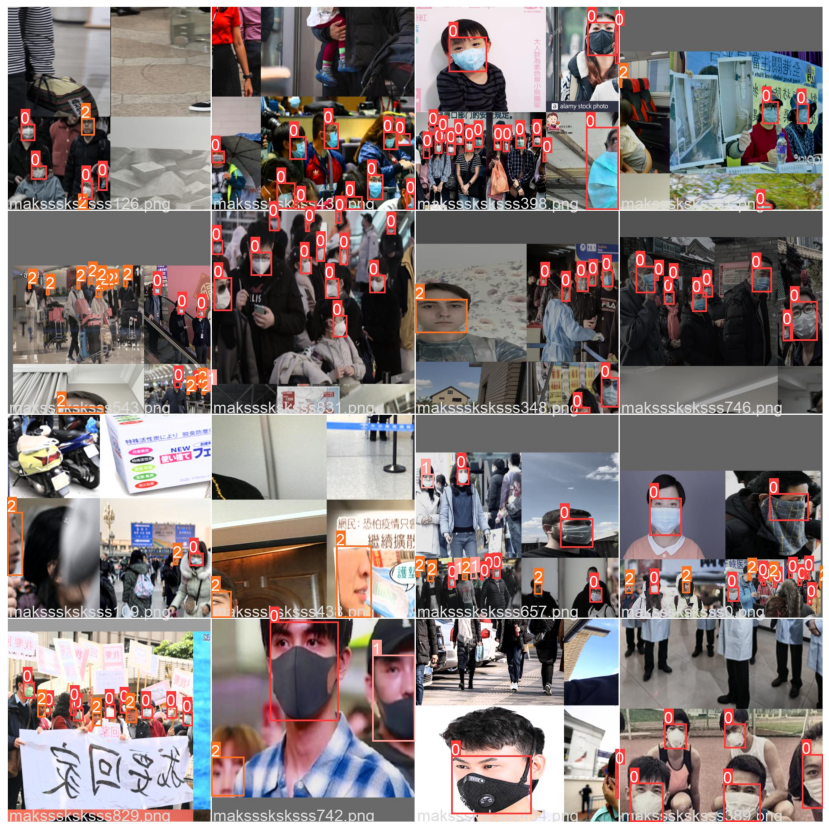

In [82]:
# lets visualize the training results
img = plt.imread('runs/train/yolov5s_results/train_batch0.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

# Test the Model
lets test the model over test images we had separated before training

In [83]:
!python3 detect.py --source data/test/images/ --weight runs/train/yolov5s_results/weights/best.pt --name expTestImage --conf 0.4

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=data/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-105-gd257c75 torch 1.12.0+cu102 CPU

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7251912 parameters, 0 gradients
image 1/25 /home/dung/Desktop/face-mask-detection/notebook/yolov5/data/test/images/maksssksksss151.png: 480x640 9 with_masks, Done. (0.121s)
image 2/25 /home/dung/Desktop/face-mask-detection/notebook/yolov5/data/test/images/maksssksksss164.png: 480x640 6 with_masks, 3 without_masks, Done. (0.091s)
image 3/25 /home/dung/Desktop/face-mask-detection/notebook/yolov5/data/test/images/ma

results are saved inside run/detect/expTestImage dir <br>
let's check the results to see how our model performed

In [84]:
color_dict = {
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect':  (0, 0, 255),
    'without_mask': (255, 0, 0) 
}

In [85]:
def show_image(img_id):
    df_image = df[df.file==img_id]
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = 'data/test/images/'+img_id# +'.png'
    img = plt.imread(path)

    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)

    img_pred = plt.imread('runs/detect/expTestImage/'+img_id)
    # ===================================
    plt.figure(figsize=(14,17))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Image with Truth Box')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')

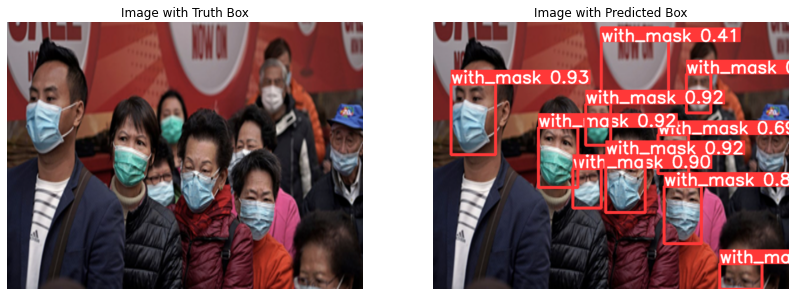

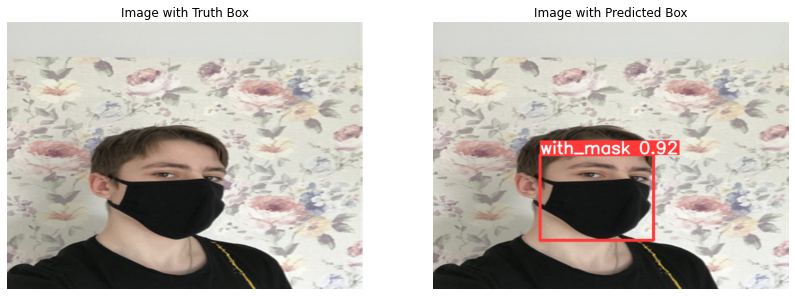

In [87]:
import os, random
show_image(random.choice(os.listdir("data/test/images/"))) 
show_image(random.choice(os.listdir("data/test/images/"))) 
plt.show()